In [6]:
# Import necessary modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from dtw import *
from collections import defaultdict
from itertools import combinations, product
from pprint import pprint
import time 
import pickle

%matplotlib inline

print("> All necessary modules imported")

> All necessary modules imported


In [2]:
def _signature_properties(windows):
    """
    Compute the features (x, y, vx, vy, pressure) of the given window
    """
    signatures = []
    
    for iteration, window in enumerate(windows):
        line = window.split(" ")
        # Purpose of line[6] ? --> it removes the \n of each line
        line[6] = line[6].strip()
        
        # Get the values used to compute the features of each window        
        t, x, y, pressure = [float(val) for val in line[:4]]
        
        # If first iteration -> delta = 0
        if iteration==0:
            vx = 0.0
            vy = 0.0
        else:
            prev_t, prev_x, prev_y = previous_txy
            vx = float((x - prev_x) / (t - prev_t))
            vy = float((y - prev_y) / (t - prev_t))
            
        # Store the previous values of the time, the x and y coordinatees to compute vx, vy at next iteration
        previous_txy = (t, x, y)
        signatures.append([x, y, vx, vy, pressure])     
    return np.asarray(signatures)


def storeSignaturesFeaturesOfEachAuthor(authorsFile, allSignaturesFolder):
    """
    Store features of genuine signatures for each writer --> Each writer has 5 genuine signatures
    """
    # Open the file containing all authors and store them in a list
    with open(authorsFile, 'r') as f:
        authorsList = [line.split(" ")[0].strip()
                       for line in f.readlines()]
    
    authorSignatures = defaultdict(list)
    nb_signatures_per_author = 5
    
    # Open each signature file for all authors
    for author, i in product(authorsList, range(nb_signatures_per_author)):
        signatureList = []
        filename = f"{allSignaturesFolder}{author}-g-0{i+1}.txt"
        
        with open(filename, "r") as signature:
            
            # Get all windows of the signatures
            windows = signature.readlines()
            
            # Compute the features vector of the signature
            signatureFeatures = _signature_properties(windows)
            
            # Append the features vector to the dictionary
            authorSignatures[author].append(signatureFeatures)
            
    return authorSignatures   
                    
allGenuineSignatures = storeSignaturesFeaturesOfEachAuthor("./users.txt", "./enrollment/")
print("> All features of all genuine signatures for each writer stored")

> All features of all genuine signatures for each writer stored


In [3]:
def storeVerificationSignature(verificationSignaturesFolder):
    """
    Load verification data: 45 signatures per writer, 20 genuine and 25 forgeries
    """
    authorSignatures = defaultdict(list)
    
    # Open all files of the given directory
    for fileName in os.listdir(verificationSignaturesFolder):
        with open(verificationSignaturesFolder+fileName, "r") as signature:
            # Get all windows of the opened signature
            windows = signature.readlines()
        
        # Compute the features vector of the given signatures    
        signatureList = _signature_properties(windows)
        
        # Compute the k=author_name and append the features vector to the list of the chosen author
        author_name, *_ = fileName.replace(".txt", "").split("-")
        authorSignatures[author_name].append(signatureList)
        
    return authorSignatures

verificationSignatures = storeVerificationSignature("./verification/")
print("> All features of all verification signatures for each writer stored")
    

> All features of all verification signatures for each writer stored


In [4]:
# Compute the average distance between all genuine signatures for each writer
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from itertools import combinations

def _normalize_size(signature, diff):
    """
    Add zeros at the end of the given signature. Used to normalize
    the signature size for the mean distance computation.
    """
    extra_zeros = np.zeros((np.abs(diff), 5))
    
    return np.concatenate((signature, extra_zeros), axis=0)

def _compute_dist(signature_a, signature_b):
    """
    Compute the DTW distance
    """
    diff_length = len(signature_a) - len(signature_b)
            
    if diff_length > 0:
        signature_b = _normalize_size(signature_b, diff_length)
    elif diff_length < 0:
        signature_a = _normalize_size(signature_a, diff_length)
    
    dist = sakoeChibaDTW(signature_a, signature_b, 50)
    
    return dist

def meanDistance(allGenuineSignatures):
    """
    Compute the mean distance between all genuine signature of each author
    """
    meanDistanceForEachAuthor = {}
    for author, signatures in allGenuineSignatures.items():
        allDistances = [_compute_dist(sign_a, sign_b)
                        for sign_a, sign_b
                        in combinations(signatures, 2)]
        
        meanDistanceForEachAuthor[author] = np.mean(allDistances)
    return meanDistanceForEachAuthor

meanDistanceForEachAuthor = meanDistance(allGenuineSignatures)
print("The mean distance of all genuine signatures for each author has been created")


    
            


The mean distance of all genuine signatures for each author has been created


In [14]:
def computeAllDistance(genuineSignatures, testSignatures):
    """
    Compute the mean distance between to all genuine signatures for each test signature of each author
    """
    
    # dictionary {author:[meanTestSignature1WithAllGenuine, meanTestSignature2WithAllGenuine, ...]}
    # Important: the order in the list corresponds to signature1, signature 2, signature3, etc..
    meanPerTestSignature = {}
    for author in testSignatures.keys():
        print("> Start author: ", author)
        start_time = time.perf_counter()
        meanPerTestSignature[author] = []
        for index, testSignature in enumerate(testSignatures[author]):
            dists = []
            start_time2 = time.perf_counter()
            
            # Compute the distance from one test signature to the 5 genuine of the author
            for genuineSignature in genuineSignatures[author]:
                dists.append(sakoeChibaDTW(testSignature, genuineSignature, 50))
                
            # Compute the mean distance
            meanDist = np.mean(dists)
            meanPerTestSignature[author].append(meanDist)
            print(">> Mean distance from the test signature", index,"to the 5 genuine signatures computed in", float(time.perf_counter()-start_time2),"[s]")
        print("> All distances for all signatures of this author computed in", float(time.perf_counter()-start_time),"[s]")

    return meanPerTestSignature
            
        
allMeanDistances = computeAllDistance(allGenuineSignatures, verificationSignatures)
print(allMeanDistances)
            
        

> Start author:  001
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 0.41031629999997676 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 0.4008475999999064 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 1.2775450999999975 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 1.1943043999999645 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 0.4418298999999024 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 0.3896588000000065 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 1.3112739000000602 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 0.4385138000000097 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 0.47002249999991363 [s]
>> Mean distance from t

>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 0.9417496000000938 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 1.0632410999999138 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 0.9948159000000487 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 3.4435595000002195 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 3.1537645999999313 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 3.4143536999999924 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 3.203325500000119 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 1.1198851999999988 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 1.3323281000000406 [s]
>> Mean distance from the test signatu

>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 2.824966499999846 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.5343744000001607 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 1.7897603000001254 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 1.8454176000000189 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 2.1859015 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 2.1520909999999276 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 2.4479552000002514 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 2.2960252999996555 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 1.5239206000001104 [s]
>> Mean distance from the test signature 26 to 

>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 5.445143100000223 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 5.588377900000069 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 5.643784900000355 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 3.1426916000000347 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 4.440503600000284 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 4.9045687000002545 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 7.538842700000259 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 6.393202100000053 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 3.8501132999999754 [s]
>> Mean distance from the test signature 12 to the

>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 3.6000684000000547 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 1.9095243000001574 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 3.614410200000293 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 2.3040487999996913 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 1.5805205000001479 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 2.0018339999996897 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 4.655509300000176 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 1.8323860000000423 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 1.6412473000000318 [s]
>> Mean distance from the test signatur

>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 7.992844800000057 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 22.071929499999897 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 4.836407400000098 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 4.68696349999982 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 8.167526600000201 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 3.7276857000001655 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 12.95561250000037 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 4.407757599999968 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 5.787055300000247 [s]
>> Mean distance from the test signature 30 t

>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 5.545556699999906 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 21.406339599999683 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 6.3634634000000005 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 4.7015652000000046 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 21.83582209999986 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 80.7475413000002 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 5.32187120000026 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 68.66533440000012 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 5.966737499999908 [s]
>> Mean distance from the test signature 16 to t

>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 8.53444649999983 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 1.7477245999998559 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 9.270746600000166 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 6.823993799999698 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 1.619533300000512 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 10.10774450000008 [s]
> All distances for all signatures of this author computed in 262.6675978999997 [s]
> Start author:  013
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 7.220211699999709 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 2.2739620000002105 [s]
>> Mean distance from the test signature 2 to th

>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 5.36137140000028 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 5.043496799999957 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 22.053667199999836 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 6.727796500000295 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 21.128449799999544 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 9.724037299999509 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 5.89715410000008 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 4.459185400000024 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 10.67366579999998 [s]
>> Mean distance from the test signature 34 to

>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 0.11823819999972329 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 0.24634749999950145 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 0.11855539999942266 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 0.13463880000017525 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 0.12984920000053535 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 0.12477600000056555 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 0.18365999999969063 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 0.1520807999995668 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 0.1267373000000589 [s]
>> Mean distance from the test

>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 0.22524950000024546 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 0.17204779999974562 [s]
> All distances for all signatures of this author computed in 12.356368599999769 [s]
> Start author:  018
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 5.740337500000351 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 1.4184228999993138 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 1.4366614000000482 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 5.600750900000094 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 1.5899452000003294 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 1.5215814000002865 [s]
>> Mean distance from the test signature 6 t

>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 1.432391500000449 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 1.3282510999997612 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 1.2869535999998334 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 1.1277424999998402 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 1.1221998000000895 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 1.4305396999998266 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 1.097609299999931 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 1.1027672000000166 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 1.3428356000003987 [s]
>> Mean distance from the test signatur

>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 0.5247075000006589 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 0.6228440000004412 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 0.5088684999991528 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.2693632000000434 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 0.5259444000002986 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 0.5067403000002741 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 0.48459989999992104 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 0.5139006999997946 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 0.5398409999997966 [s]
>> Mean distance from the test signa

>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 0.8218512000003102 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 0.8276861999993343 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 0.869000199999391 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 1.2633241000003181 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 0.39345760000014707 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 0.5323895999999877 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 0.3855989999992744 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 0.7589763000005405 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 0.37982889999966574 [s]
>> Mean distance from the test signature 9 to

>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 1.737215400000423 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 2.5203428999993776 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 2.7092102999995404 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 4.1951254000005065 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 0.9799117000002298 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 2.6301118999999744 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 1.8442391999997199 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 1.034782699999596 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 0.9996769999997923 [s]
>> Mean distance from the test signatur

>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 18.299713400000655 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 17.66186689999995 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 10.7736361999996 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 17.007976099999723 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 4.740220399999998 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 7.955669499999203 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 4.724872900000264 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 5.780775299999732 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 10.779535800000303 [s]
>> Mean distance from the test signature 26 

>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 1.0599099000000933 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 0.8132234000004246 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 0.7548907999998846 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 0.8702460000004066 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 1.3608594999996058 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 0.7938947000002372 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 0.7681218000006993 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 0.8063253000000259 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 1.5449480999996013 [s]
>> Mean distance from the test signature 11 t

>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 0.322045299999445 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 0.283845900000415 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 0.2583679999997912 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 0.3070023999998739 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 0.2559698000004573 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 0.25626680000004853 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 0.2349770000000717 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 0.34258690000024217 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 0.2820670000000973 [s]
>> Mean distance from the test signat

In [17]:
import pickle

def save_obj(obj, name ):
    """
    Save the given object in a file
    """
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    print("> Mean distance of all test signatures stored in:", 'obj/' + name + '.pkl')
        
savedData = save_obj(allMeanDistances,"testSignatures")


> Mean distance of all test signatures stored in: obj/testSignatures.pkl


In [7]:
def load_obj(name ):
    """
    Retrieve the object contained in the given file
    """
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
data = load_obj("testSignatures")
print("> Mean distance of all test signatures retrieved")

> Mean distance of all test signatures retrieved


In [9]:
def predict(testSignatures):
    """
    Predict the class of all verification signature
    """
    thresholds = [i for i in range(0, 50000, 50)]
    prediction = {}
    for threshold in thresholds:
        prediction[threshold]={}
        for author in testSignatures.keys():
            for index,signature in enumerate(testSignatures[author]):
                if abs(signature-meanDistanceForEachAuthor[author])<threshold:
                    if index<9:
                        prediction[threshold][str(author)+"-0"+str(index+1)]='g'
                    else:
                        prediction[threshold][str(author)+"-"+str(index+1)]='g'
                else:
                    if index<9:
                        prediction[threshold][str(author)+"-0"+str(index+1)]='f'
                    else:
                        prediction[threshold][str(author)+"-"+str(index+1)]='f'
    return prediction

allPredictions = predict(data)
print("> Prediction successfully done ")

    
    

> Prediction successfully done 


In [12]:
def evaluate(allPredictions):
    """
    Compute the accuracy of the algorithm using the ground truth
    """
    groundTruth = {}
    accuracy = {}
    with open("gt.txt", "r") as myfile:
        lines = myfile.readlines()
        for l in lines:
            a = l.replace("\n", "").split(" ")
            groundTruth[a[0]] = a[1]
        
    for threshold in allPredictions.keys():
        correct = 0
        wrong = 0
        for signature in allPredictions[threshold].keys():
            if groundTruth[signature]==allPredictions[threshold][signature]:
                correct+=1
            else:
                wrong+=1
        accuracy[threshold]= correct/(correct+wrong)
    return accuracy

accuracyList = evaluate(allPredictions)
print("> Dictionary of accuracy for each threshold generated")
        

> Dictionary of accuracy for each threshold generated


In [13]:
print(accuracyList)

{0: 0.5555555555555556, 50: 0.5585185185185185, 100: 0.5592592592592592, 150: 0.56, 200: 0.5607407407407408, 250: 0.5622222222222222, 300: 0.5614814814814815, 350: 0.5622222222222222, 400: 0.5637037037037037, 450: 0.5651851851851852, 500: 0.5666666666666667, 550: 0.5688888888888889, 600: 0.5718518518518518, 650: 0.5748148148148148, 700: 0.5792592592592593, 750: 0.5792592592592593, 800: 0.577037037037037, 850: 0.5814814814814815, 900: 0.582962962962963, 950: 0.5844444444444444, 1000: 0.5851851851851851, 1050: 0.5881481481481482, 1100: 0.5911111111111111, 1150: 0.5940740740740741, 1200: 0.5955555555555555, 1250: 0.5955555555555555, 1300: 0.5985185185185186, 1350: 0.5992592592592593, 1400: 0.6007407407407407, 1450: 0.6022222222222222, 1500: 0.6074074074074074, 1550: 0.6081481481481481, 1600: 0.6103703703703703, 1650: 0.6133333333333333, 1700: 0.6148148148148148, 1750: 0.6162962962962963, 1800: 0.6177777777777778, 1850: 0.6192592592592593, 1900: 0.6192592592592593, 1950: 0.6207407407407407

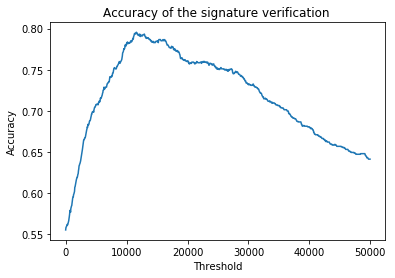

In [23]:
def visualize(accuracy):
    lists = sorted(accuracy.items()) 
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.title("Accuracy of the signature verification ")
    plt.xlabel("Threshold")
    plt.yscale('linear')
    plt.ylabel("Accuracy")
    plt.show()
visualize(accuracyList)

In [26]:
"""Re-arrange data to generate the output"""

def rearrange_data(data):
    # rearranged_data looks like: {authorID: {signatureID: distance}}
    rearranged_data = dict()
    
    for k, v in data.items():
        sub_dict = dict()
        for index, value in enumerate(v):
            sub_dict[str(index+1) if index+1 > 9 else '0' + str(index+1)] = value
        rearranged_data[k] = sub_dict
    return rearranged_data

rearranged_data = rearrange_data(data)
print(rearranged_data)

{'001': {'01': 13001.333166272263, '02': 11908.515575917567, '03': 43409.92617170668, '04': 54717.993599174704, '05': 12353.227673980806, '06': 41630.77439716559, '07': 47866.69401646619, '08': 14417.930715546265, '09': 12082.915756786912, '10': 30563.906886321736, '11': 12562.930793462274, '12': 48137.7766193875, '13': 15334.088776816756, '14': 12048.98721299005, '15': 28884.376938129968, '16': 13928.663978519577, '17': 13748.52724458207, '18': 15037.49686369397, '19': 14929.452795900961, '20': 31322.779500425626, '21': 35244.213478989914, '22': 15689.138296084082, '23': 15780.555239011712, '24': 49070.49807795612, '25': 47274.01406461514, '26': 15752.883828493126, '27': 45304.36049484494, '28': 17214.04924326005, '29': 11564.229849914438, '30': 46885.74099557013, '31': 42007.492896334836, '32': 49115.57821433876, '33': 13932.810638669116, '34': 43237.85881512962, '35': 46553.564243990826, '36': 27962.152250528627, '37': 15614.184148653696, '38': 31891.937756600535, '39': 51067.210667

In [27]:
"""Export results to match the requested output format"""

def export_results(rearranged_data):
    # create output directory if needed
    if not os.path.exists('./Output/'):
        os.makedirs('./Output/')
    
    # generate output
    output_str = ''
    for authorID, distances in rearranged_data.items():
        output_str += '{}'.format(authorID)
        for id, dist in distances.items():
            output_str += ', {}, {}'.format(id, dist)
        output_str += '\n'
        
    output_str = output_str.rstrip() # remove the last \n
    
    # export output
    with open("./Output/output.txt", "w") as output_file:
        output_file.write(output_str)
    
    # print as verification
    print(output_str)


export_results(rearranged_data)

001, 01, 13001.333166272263, 02, 11908.515575917567, 03, 43409.92617170668, 04, 54717.993599174704, 05, 12353.227673980806, 06, 41630.77439716559, 07, 47866.69401646619, 08, 14417.930715546265, 09, 12082.915756786912, 10, 30563.906886321736, 11, 12562.930793462274, 12, 48137.7766193875, 13, 15334.088776816756, 14, 12048.98721299005, 15, 28884.376938129968, 16, 13928.663978519577, 17, 13748.52724458207, 18, 15037.49686369397, 19, 14929.452795900961, 20, 31322.779500425626, 21, 35244.213478989914, 22, 15689.138296084082, 23, 15780.555239011712, 24, 49070.49807795612, 25, 47274.01406461514, 26, 15752.883828493126, 27, 45304.36049484494, 28, 17214.04924326005, 29, 11564.229849914438, 30, 46885.74099557013, 31, 42007.492896334836, 32, 49115.57821433876, 33, 13932.810638669116, 34, 43237.85881512962, 35, 46553.564243990826, 36, 27962.152250528627, 37, 15614.184148653696, 38, 31891.937756600535, 39, 51067.21066703165, 40, 45039.13436596114, 41, 46622.03212497581, 42, 38192.623600299085, 43, 1